# Машинное обучение, DS-поток
## Домашнее задание 9

**Правила:**

* Дедлайн **08 мая 16:30**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[ml] Фамилия Имя - задание 9"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов). Названия файлов должны быть такими: `9.N.ipynb` и `9.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Теоретические задачи необходимо оформить в техе/markdown или же прислать фотку в правильной ориентации рукописного решения, **где все четко видно**.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -- 2 балла
* Задача 2 -- 10 баллов

### Задача 1.


Докажите, что в методе k-means кластеры образуют выпуклые множества. Выполняется ли данное свойство для кластеров, определеяемых гауссовской смесью? Под кластером имеется в виду область пространства признаков.

**Решение:**

**a).** Пусть точки $x_1$ и $x_2$ лежат в одном кластере с номером $k$. Покажем, что точка $\lambda x_1 + (1-\lambda)x_2$ при $\lambda \in (0, 1)$ также лежит в нем, что будет означать выпуклость кластера. 

По построению метода получаем, что для любого другого кластера $s$ выполнено $\|x_i - \mu_k\|^2 < \|x_i - \mu_s\|^2,$ где $\mu_k$ и $\mu_s$ -- центры соответствующих кластеров.

Раскроем скобки в этом неравенстве: $$\|x_i\|^2 - 2\langle x_i, \mu_k\rangle + \|\mu_k\|^2 < \|x_i\|^2 - 2\langle x_i, \mu_s\rangle + \|\mu_s\|^2.$$

Сократим
$$- 2\langle x_i, \mu_k\rangle + \|\mu_k\|^2 < - 2\langle x_i, \mu_s\rangle + \|\mu_s\|^2.$$

Просуммируем неравенства для $i=1,2$ с весами $\lambda$ и $1-\lambda$:
$$- 2\langle \lambda x_1 + (1-\lambda)x_2, \mu_k\rangle + \|\mu_k\|^2 < - 2\langle \lambda x_1 + (1-\lambda)x_2, \mu_s\rangle + \|\mu_s\|^2.$$

Добавим к обеим частям норму $x_1 + (1-\lambda)x_2$ и сгруппируем
$$\|\lambda x_1 + (1-\lambda)x_2\|^2 - 2\langle \lambda x_1 + (1-\lambda)x_2, \mu_k\rangle + \|\mu_k\|^2 < \|\mu_k\|^2 - 2\langle \lambda x_1 + (1-\lambda)x_2, \mu_s\rangle + \|\lambda x_1 + (1-\lambda)x_2\|^2,$$
$$\|(\lambda x_1 + (1-\lambda)x_2) - \mu_k\|^2 < \|(\lambda x_1 + (1-\lambda)x_2) - \mu_s\|^2.$$

В силу произвольности кластера $s$ получаем, что точка $\lambda x_1 + (1-\lambda)x_2$ также лежит в кластере $k$.

**б).** Для гауссовской смеси это может быть не верно. Например, если компоненты гауссовской смеси имеют центр в нуле и матрицы ковариаций $\begin{pmatrix} 1 & 0 \\ 0 & 1\end{pmatrix}$ и $\begin{pmatrix} 2 & 0 \\ 0 & 2 \end{pmatrix}$. Разделяющим подпространством является сфера.

### Задача 2.

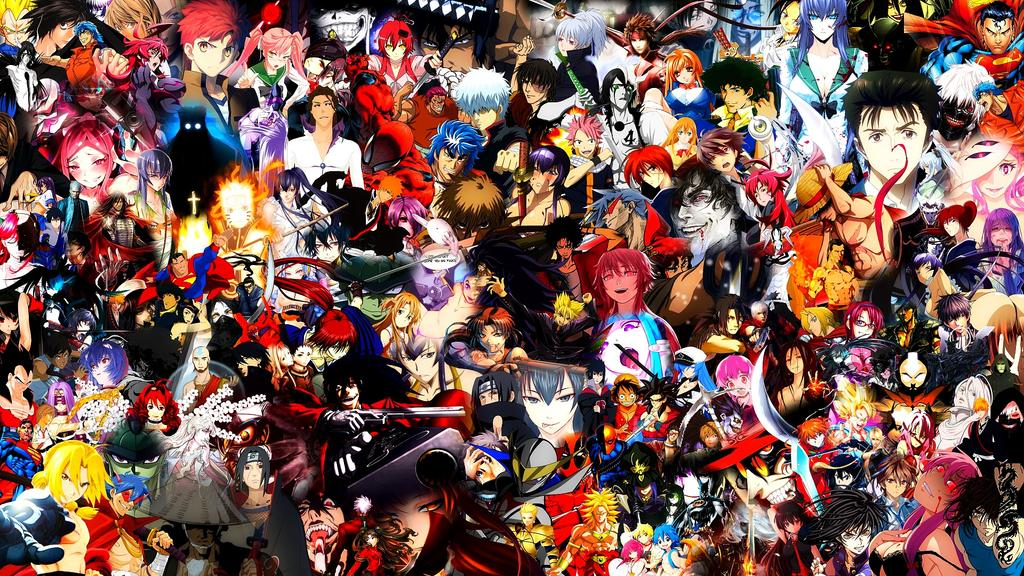

К вам пришли друзья-анимешники и попросили порекомендовать хорошее аниме. Все что им раньше советовали они уже посмотрели и теперь хотят чего-то нового. Теперь перед вами стоит задача порекомендовать друзям подходящие аниме и построить несложную рекомендательную систему. Кроме того, вы хотели бы посмотреть, какие вообще группы анимешников бывают.

Как же это сделать?...

Идея!  

Сгруппировать любителей аниме на несколько кластеров. Тогда для того, чтобы предсказать интересное аниме для пользователя, нужно сначала определить место этого пользователя в кластере, а потом на основе предпочтений остальных пользователей в этом кластере определить подходящие аниме для данного пользователя.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, style='whitegrid', palette='Set2')
from tqdm.notebook import tqdm
from umap import UMAP
import scipy.stats as sps
import scipy as sp
import pickle
import joblib
from sklearn.mixture import GaussianMixture
from IPython.display import display
from statsmodels.stats.multitest import multipletests

import warnings
warnings.simplefilter("ignore")

#### Предобработка данных

Скачайте датасет `anime.csv`. В нем вам понадобятся колонки `anime_id`, название аниме `name`, жанр `genre` и рейтинг `rating`.  Изучите основные характеристики датасета: размер, имеющиеся признаки, наличие пропусков и тому подобное. Если пропусков мало по сравнению с размером данных, то можно их удалить.

In [2]:
anime = pd.read_csv('../../ML/Clustering/anime.csv')[['anime_id','name', 'genre', 'rating']]
anime.head()

,anime_id,name,genre,rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",9.25
3,9253,Steins;Gate,"Sci-Fi, Thriller",9.17
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",9.16


In [3]:
anime.shape

(12294, 4)

In [4]:
anime.isna().sum()

anime_id      0
name          0
genre        62
rating      230
dtype: int64

>Так как пропусков значительно меньше чем объектов в данных, то удалим объекты с пропусками.

In [5]:
anime = anime.dropna(how='any')

Скачайте датасет `rating.csv`. Так же изучите основые характеристики датасета.

In [6]:
rating = pd.read_csv('../../ML/Clustering/rating.csv')
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
rating.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

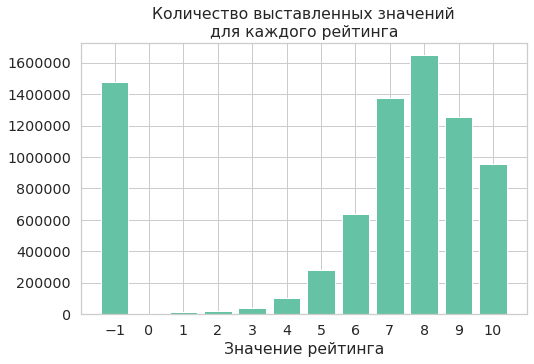

In [8]:
plt.figure(figsize=(8, 5))
plt.bar(*np.unique(rating.rating, return_counts=True))
plt.xticks(np.arange(-1, 11))
plt.title('Количество выставленных значений\nдля каждого рейтинга')
plt.xlabel('Значение рейтинга');

>Наблюдается большое количество значений -1. Так не может быть отрицательная оценка настолько частой, то значит -1 указывает на пропуск оценки.  
>
> Посмотрим на распределение того, сколько значимых оценок ставят пользователи.

In [9]:
user, user_counts = np.unique(rating.user_id[rating.rating != -1], return_counts=True)
np.quantile(user_counts, 0.25), np.median(user_counts), np.quantile(user_counts, 0.75)

(13.0, 45.0, 114.0)

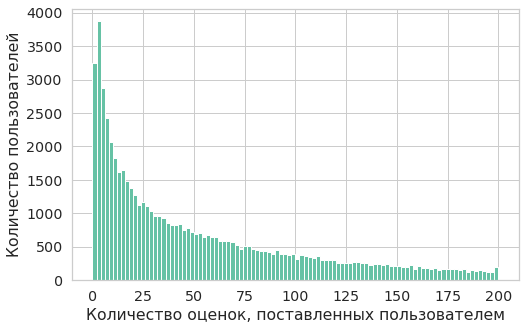

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(user_counts, bins=100, range=(0, 200))
plt.xlabel('Количество оценок, поставленных пользователем');
plt.ylabel('Количество пользователей');

In [11]:
user_counts[user_counts < 30].sum(), user_counts[user_counts >= 30].sum()

(311537, 6025704)

> В большей своей части пользователи хоть как-то оценили более 30 аниме. Поэтому далее в решении было предложено отсечь пользователей, которые посмотрели меньше 30 аниме.

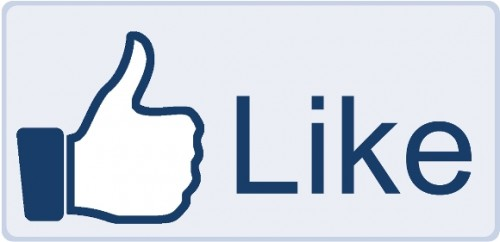

Посмотрите распределение оценок аниме у различных пользователей. Наблюдаются ли какие-то проблемы? 

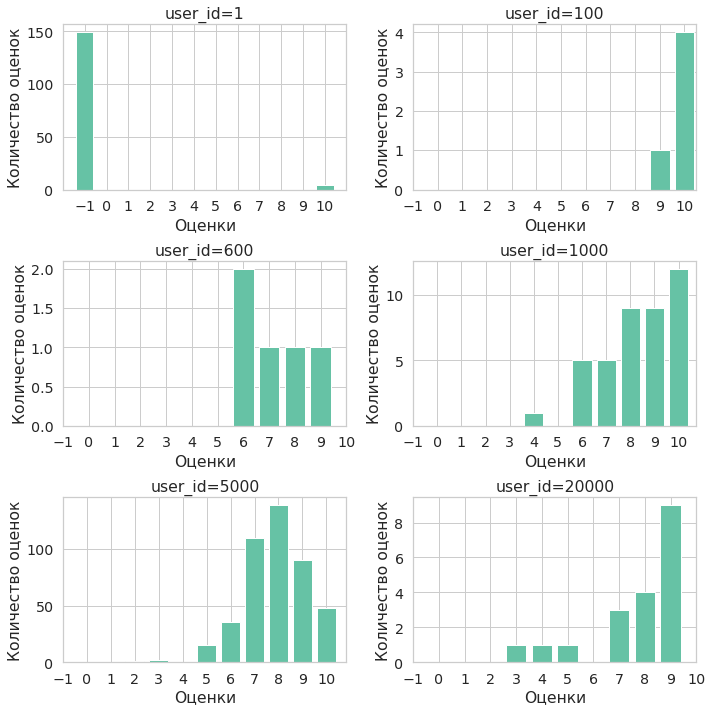

In [12]:
plt.figure(figsize=(10, 10))
for i, n in zip(range(6), [1, 100, 600, 1000, 5000, 20000]):
    plt.subplot(3, 2, i + 1)
    plt.bar(*np.unique(rating[rating['user_id'] == n]['rating'], return_counts=True))
    plt.xticks(np.arange(-1, 11))
    plt.title(f'user_id={n}')
    plt.xlabel('Оценки')
    plt.ylabel('Количество оценок')
    
plt.tight_layout()

Подумайте над тем, как бы сделать рейтинг более адекватным. Лучше всего сделать так, чтобы худшее аниме получило рейтинг -1, а лучшее аниме &mdash; рейтнг 1. Можно попробовать разбить оценки просто по порогам. Можно придумать что-то еще более хитрое. Не стоит много времени тратить на размышление -- подробнее с темой рекомендательных систем вы познакомитесь в следующем семестре :) Однако нужно пояснить свою методику. 

Внимание! Если в данных есть пропуски, то мы не можем сказать ничего о позитивном или негативном отношении пользователя к аниме, тогда поставьте 0 в качестве оценки. 

> Посмотрим также на распределение максимальных, минимальных и средних оценок по пользователям.

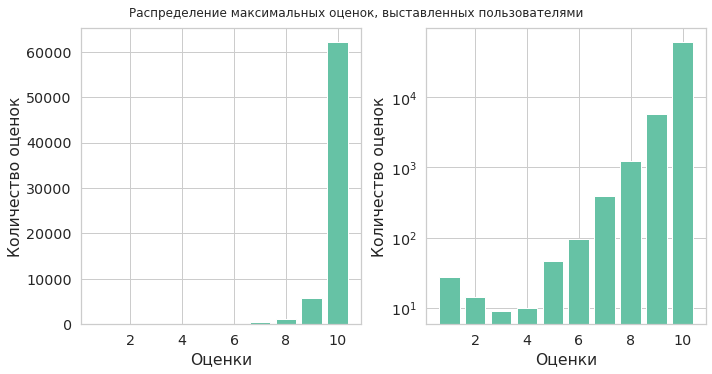

In [13]:
rait,  num = np.unique(
    rating[rating.rating >= 1].groupby('user_id').max()['rating'], 
    return_counts=True
)

fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(rait, num)
plt.xlabel('Оценки')
plt.ylabel('Количество оценок')

plt.subplot(1, 2, 2)
plt.bar(rait, num)
plt.xlabel('Оценки')
plt.ylabel('Количество оценок')
plt.yscale('log')

fig.suptitle('Распределение максимальных оценок, выставленных пользователями', y=1.03)
plt.tight_layout()

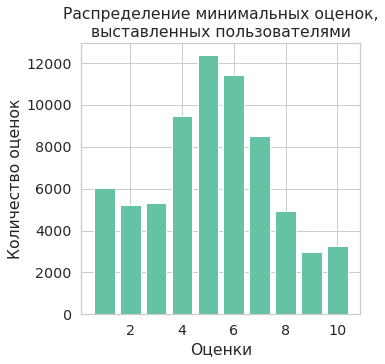

In [14]:
rait,  num = np.unique(
    rating[rating.rating >= 1].groupby('user_id').min()['rating'], 
    return_counts=True
)

fig = plt.figure(figsize=(5, 5))
plt.bar(rait, num)
plt.title('Распределение минимальных оценок,\nвыставленных пользователями')
plt.xlabel('Оценки')
plt.ylabel('Количество оценок');

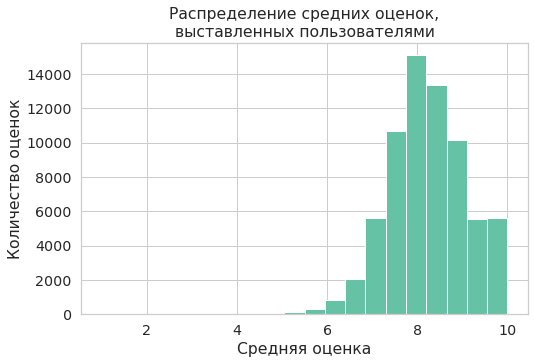

In [15]:
mean = rating[rating.rating >= 1].groupby('user_id').mean()['rating']

fig = plt.figure(figsize=(8, 5))
plt.hist(mean, bins=20)
plt.title('Распределение средних оценок,\nвыставленных пользователями')
plt.xlabel('Cредняя оценка')
plt.ylabel('Количество оценок');

> Выделим главные особенности в оценках.  
*Во-первых*, у пользователей есть субъективное мнение на выставление оценок. Более позитивные пользователи выбирают оценки из диапазона от 7 до 10, например, а более критичные &mdash; от 1 до 6.  
*Во-вторых*, некоторые люди смотрят только то, что им нравится. И если минимальная оценка, выставленная ими равна 8, то это не значит, что аниме им вовсе не понравилось.  
Для того, чтобы решить первую проблему, будем нормировать пользоваетелей по выставленных ими оценкам. Для того чтобы решить вторую проблему выставим среднюю оценку, равную 8, для пользователей, которые завышают оценки, так скорее всего они смотрят то, что им нравится.

Обновите рейтинг в соотвествии с вашей методикой. Удалите пользователей, которые оценили менее 30 аниме.

In [16]:
# Удаляем пользователей, которые оценили менее 30 аниме.
nan_rating_mask = rating['rating'] == -1
user_mask = rating.loc[~nan_rating_mask].groupby('user_id')['rating'].count() >= 30
user_id = user_mask.index[user_mask.values]
rating = rating.loc[np.in1d(rating['user_id'], user_id)]

In [17]:
# Находим минимальные и максимальные оценки для каждого пользователя
nonan_rating_mask = (rating['rating'] != -1).values
max_rate = rating.loc[nonan_rating_mask].groupby('user_id')['rating'].max()
min_rate = rating.loc[nonan_rating_mask].groupby('user_id')['rating'].min()
# Считаем срреднюю оценку по каждому пользователю
# Если средняя оценка пользователя завышена, то приводим ее к 8.
user_id = max_rate.index
mean_rate = rating.loc[nonan_rating_mask].groupby('user_id')['rating'].mean()
mean_rate[mean_rate > 8] = 8
# Считаем нормировку для отдельно 
# для оценок выше среднего 
# и для оценок ниже среднего
scale1 = max_rate - mean_rate
scale2 = mean_rate - min_rate

# Создаем вспомогательную таблицу
ar_temp = np.vstack([user_id, scale1, scale2, mean_rate]).T
df_temp = pd.DataFrame(
    columns=['user_id', 'scale1', 'scale2', 'mean_rate'],
    data=ar_temp
)
# Создаем новый рейтинг
rating_new = pd.merge(rating, df_temp)
# Находим разность между максимальным и средним рейтнгом.
rating_new['rating_new'] = (rating_new['rating'] - rating_new['mean_rate'])
# Если эта разность больше 0, то делим на нормировку дял оценок выше среднего.
mask = rating_new['rating_new'] > 0
rating_new.loc[mask, 'rating_new'] = rating_new.loc[mask, 'rating_new'] / rating_new.loc[mask, 'scale1']
# Если разность получилась меньше 0, о делим на нормировку для оценок ниже среднего.
mask = rating_new['rating_new'] < 0
rating_new.loc[mask, 'rating_new'] = rating_new.loc[mask, 'rating_new'] / rating_new.loc[mask, 'scale2']
# Там, где оценку не поставили, приравняем рейтинг 0.
rating_new.loc[~nonan_rating_mask] = 0
# Удаляем вспомогательные колонки
rating_new = rating_new.drop(columns=['rating', 'scale1', 'scale2', 'mean_rate'])

Объедините данные аниме и пользователей по ключу `anime_id`.

In [18]:
merged_data = pd.merge(anime, rating_new, how='inner')
merged_data.head()

,anime_id,name,genre,rating,user_id,rating_new
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37,99,-0.14658
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37,152,1.00000
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37,244,1.00000
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37,271,1.00000
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37,322,1.00000


In [19]:
merged_data.shape

(6025609, 6)

#### Кластеризация

Из таблицы с объединенными даннами, используя колонки `user_id`, `anime_id` и `rating` (персональный рейтинг аниме у пользователя), получите таблицу сопряженности, заполнив клетки этой таблицы персональным рейтингом пользователя для каждого аниме. В случае отсутствия ретинга, поставьте 0.

In [20]:
user_anime = pd.crosstab(
    index=merged_data['user_id'],
    columns=merged_data['anime_id'],
    values=merged_data['rating_new'],
    aggfunc=np.nanmean
)

user_anime = user_anime.fillna(0)
user_anime.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.645697,0.0,0.0,0.291393,0.0,0.291393,0.291393,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Выделите 5 понравившихся пользователей и вынесите их в тест. Они будут играть роль ваших друзей в задаче. Для них вы будете рекомендовать аниме.  
Для кластеризации используйте остальных пользователей. Эти данные являются трейном.

In [21]:
# Тест
user_anime_test = user_anime.loc[[17, 29, 43, 77, 93]]
# Трейн
user_anime_train = user_anime.drop(index=[17, 29, 43, 77, 93])
train_index = user_anime_train.index

Посмотрите на таблицу сопряженности и, учитывая во внимание ее размер, подумайте информативно ли расстояние между пользователями пространстве такой размерности. 

In [22]:
user_anime_train.shape

(41420, 9884)

>Расстояние в смысле евклидовой метрики вовсе не информативно когда идет речь о размероностях больше 20. В нашем случае данные имеют размерность 9884. Что сильно больше.

Попробуйте различные методы понижения размерности и сделайте вложение в пространство небольшой размерности. Но учтите, что исходя из формата данных, лучше использовать косинусную метрику для оценки расстояния между точками.

*Справка. Косинусная мера*  
Пусть заданы векторы $x, y \in \mathbb{R}^d$. Известно, что их скалярное произведение и косинус угла между ними $\varphi$ связаны следующим отношением:
$$\langle x, y \rangle = \|x\|\|y\|\cos\varphi.$$
Соотвественно, косинусное расстояние определяется как
$$\rho_{cos}(x, y) = \arccos\frac{\langle x, y \rangle}{\|x\|\|y\|} = \arccos\frac{\sum_{i=1}^{d}x_iy_i}{\sqrt{\sum_{i=1}^{d}x_i}\sqrt{\sum_{i=1}^{d}y_i }}.$$  
Чем более схожи пользователи согласно тому, как они ставят оценки, тем меньше угол между их векторами, тем ближе косинус к 1. Тогда если меру использовать для оценки расстояния, нужно от 1 отнять значение меры.

>Нам известно, что TSNE не может быть обучен на одних данных, а применяться к другим. Поэтому мы не можем его использовать, так как в итоге мы хотим найти подходящее аниме для пользоваетелей из теста. Поэтому в нашем арсинале остается 2 метода понижения размерности: PCA и UMAP. 

> Прежде чем мы применять PCA, посмотрим на долю объяснимой дисперсии в зависимости от числа компонент.

In [24]:
singular_values = np.sqrt(sp.linalg.svdvals(user_anime_train))

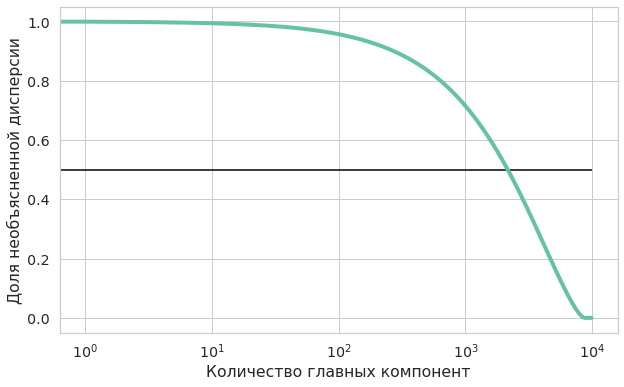

In [25]:
error = singular_values[::-1].cumsum() / singular_values.sum()
error = error[::-1]

plt.figure(figsize=(10, 6))
plt.plot(range(len(error)), error, linewidth=4)
plt.hlines(0.5, 0, 1e4)
plt.xscale('log')
plt.xlabel('Количество главных компонент')
plt.ylabel('Доля необъясненной дисперсии')
plt.show()

>Выходит, чтобы объяснить хотя бы половину дисперсии в данных нужно использовать порядка 1000 компонент. Это довольно много для последующей кластеризации. Если же мы выберем порядка 10 компонент то дисперсия практически никак не будет объяснена. Учитывая во внимание то, что есть такой метод как UMAP, который опираясь на топологические характеристики данных сохраняет кластерную структуру, то будем сразу использвать этот метод.

>Поробовав разное число компонент в UMAP: 3, 6, 10, остановимся на 6. Так как при использовании трех компонентах разделения между данными явно не проявлялось, а при 10 компонентах метр В качестве метрики поставим косинусную, как предлагается в задании.

>Так как модель вычисляется довольно долго (особенно на всех данных), то нужно сохранять результаты посчитанных моделей. Для этого можно использовать библиотеку joblib, которая в отличие от pickle, может сохраянть оченб большие данные.

In [23]:
# joblib.dump(umap6, 'umap6.jl')
# umap = joblib.load('../../ML/Clustering/umap6.jl')

>Трансформируем данные.

In [ ]:
umaped_user_anime = umap.transform(user_anime_train)

> Визуализируем трансформированные данные.

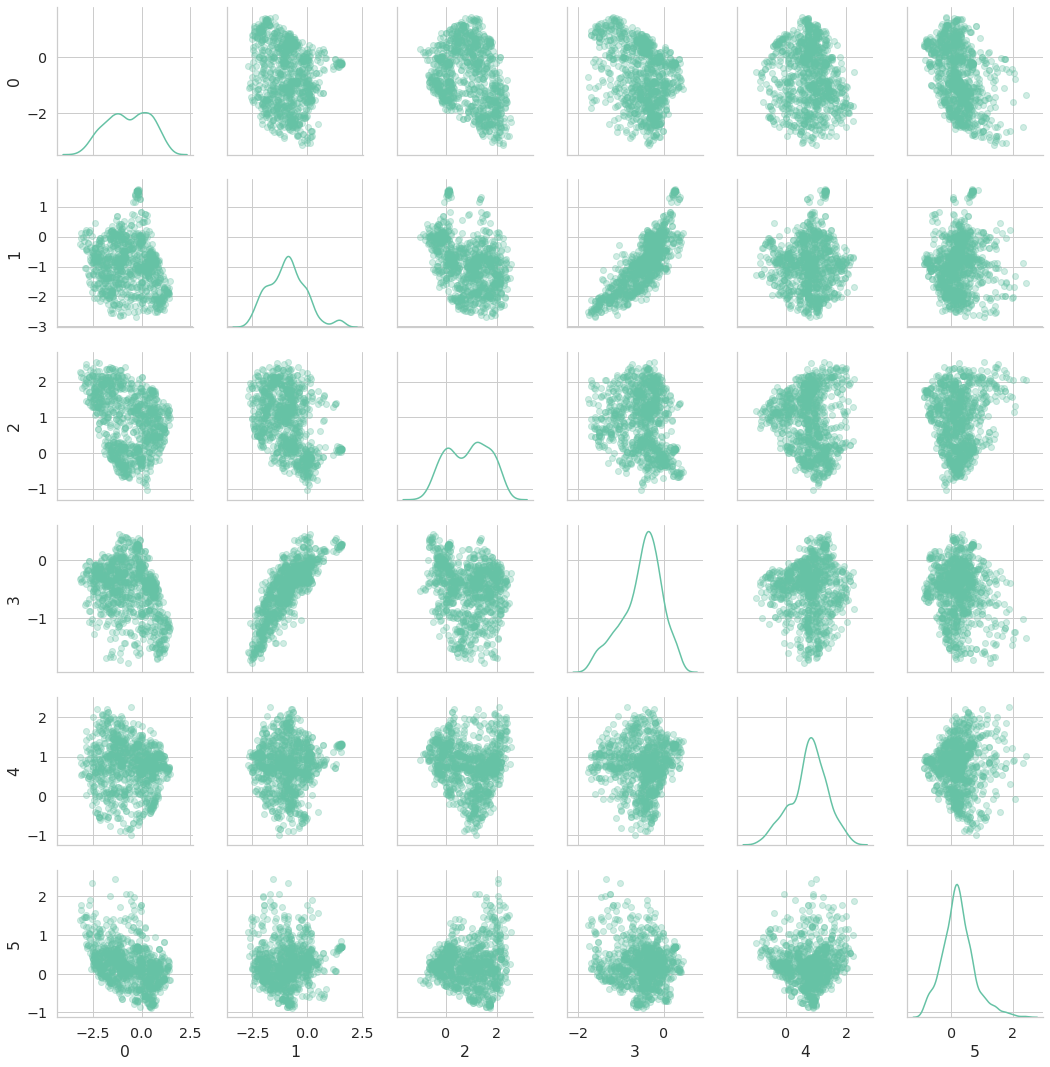

In [32]:
index = np.random.choice(len(user_anime_train), 1000)

df = pd.DataFrame(umaped_user_anime[index])
plot = sns.PairGrid(data=df)
plot.map_diag(sns.kdeplot)
plot.map_offdiag(plt.scatter, alpha=0.3);

Кластеризуйте полученное вложение в пространство меньшей размерности. 


В качестве метода кластеризации используйте k-means или же смесь гауссовских распределений в виде реализации `GaussianMixture` из sklearn c `covariance_type='spherical'`. Во втором случае в качестве ковариационных матриц компонент используются $\Sigma_k=diag(\sigma^2_k)$, где $k$ -- номер компоненты. Это соответствует более общему случаю k-means, при котором масштабы кластеров могут отличаться. Такое полезно при наличии кластеров разной плотности. 

Подберите оптимальное количество кластеров. Объясните свой выбор.

*Замечание.* В реальных задачах бывает полезно проводить кластеризацию даже при отстутствии какой-либо кластерной структуры в данных. Под кластером в таком случае подразумеваются группы похожих объектов, что облегчает решение многих практических задач. Метрики качества кластеризации, как правило, бесполезны в таких задачах. Однако, можете обратить внимание на <a href="https://en.wikipedia.org/wiki/Elbow_method_(clustering)">Elbow method</a>.

>Получим результаты кластеризации для разного количества кластеров.

In [ ]:
labels = []
centres = []
max_components = 50

for n in range(2, max_components):
    gm = GaussianMixture(n_components=n, covariance_type='spherical')
    labels += [gm.fit_predict(umaped_user_anime)]
    centres += [gm.means_]

> Получим среднюю дисперсию в кластере для разных разбиений на кластеры.

In [26]:
var = []
for n in range(2, max_components):
    var += [0]
    for i in range(n):
        var[n - 2] += ((umaped_user_anime[labels[n - 2] == i]
         - centres[n - 2][i]) ** 2).sum()
    var[n - 2] = np.sqrt(np.mean(var[n - 2]))

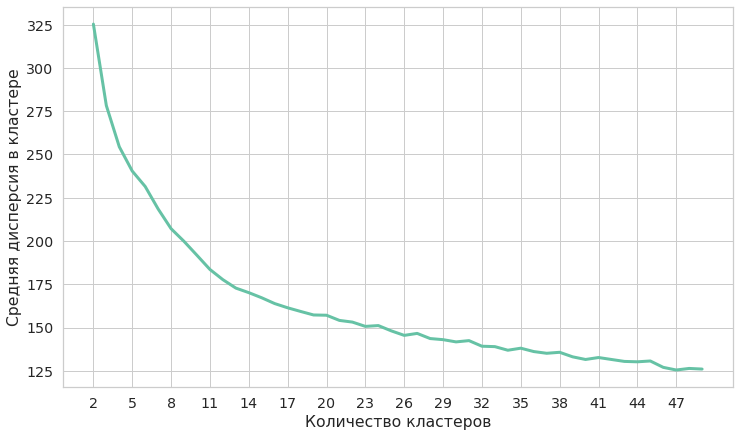

In [27]:
plt.figure(figsize=(12, 7))
plt.plot(range(2, max_components), var, lw=3)
plt.xlabel('Количество кластеров')
plt.ylabel('Средняя дисперсия в кластере')
plt.xticks(np.arange(2, max_components, 3));

>Переломный момент наблюдается для 7 кластеров. Визуализируем результат кластеризации для 7 кластеров.

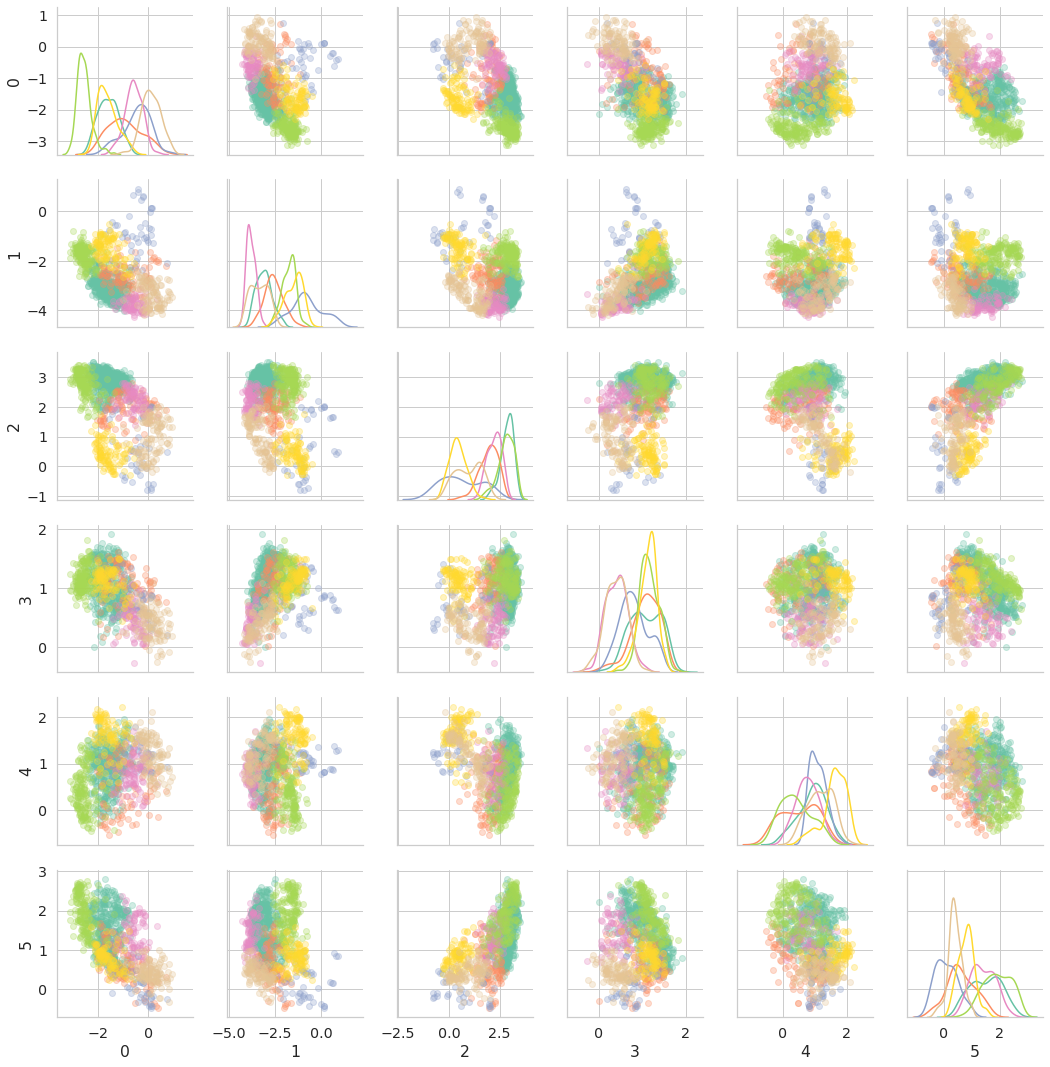

In [27]:
gm = GaussianMixture(n_components=7, covariance_type='spherical')
labels = gm.fit_predict(umaped_user_anime)
df = pd.DataFrame(np.hstack([umaped_user_anime, labels.reshape(-1, 1)]))

plot = sns.PairGrid(df.iloc[:1000], vars=range(6), hue=6)
plot.map_diag(sns.kdeplot)
plot.map_offdiag(plt.scatter, alpha=0.3);

Проанализируйте полученные кластеры, постарайтесь их проинтерпретировать, указав жанры, которые предпочитают пользователи из данного кластера. Не забывайте про статистическую значимость ваших выводов.

>Соберем все жанры аниме.

In [ ]:
all_genres = set()
for genres in anime['genre']:
    for genre in genres.split(','):
        if genre not in all_genres:
            all_genres.add(genre)

>Получим таблицу, в которой каждому аниме соотвествует несколько жанров.

In [35]:
genre_anime = pd.DataFrame(columns=list(all_genres), index=anime['anime_id'])
genre_anime = genre_anime.fillna(0)

for i in tqdm(anime.index):
    anime_id, genres = anime.loc[i, ['anime_id', 'genre']]
    
    for genre in genres.split(','):
        genre_anime.loc[anime_id, genre] = 1

>Подсчет происходит долго, поэтому стоит записать его результат

In [ ]:
# genre_anime.to_csv('genre_anime.csv')
# genre_anime = pd.read_csv('genre_anime.csv', index_col=0)

In [ ]:
genre_anime.head()

>Объединим полученную таблицу с таблицей рейтинга.

In [ ]:
genre_anime = genre_anime.reset_index()
merged_user_genre = pd.merge(rating_new, genre_anime, how='inner')
merged_user_genre.head()

>Теперь мы можем посчитать рейтинг каждого жанра по каждому юзеру. Для этого домножим данные юзерам и аниме на данные по рейтингу аниме для каждого юзера. А полченный результат усредним. Так мы получим оценку по жанрам с учетом того, как часто юзер смотрел тот или иной жанр.

In [33]:
merged_user_genre_rating = (merged_user_genre[all_genres] * merged_user_genre['rating_new'].values.reshape(-1, 1))
merged_user_genre_rating['user_id'] = merged_data['user_id']
user_genre_rating = merged_user_genre_rating.groupby('user_id').mean()
user_genre_rating.head()

,Sci-Fi,Yuri,Sci-Fi,Shoujo,Dementia,Drama,Historical,Samurai,Josei,Music,...,Super Power,Parody,Romance,Military,Seinen,Ecchi,Shoujo,Demons,Cars,Shounen
user_id,,,,,,,,,,,,,,,,,,,,,
3,inf,NaN,0.546599,1.052592,NaN,0.560734,NaN,1.000000,NaN,NaN,...,0.539299,inf,0.375960,NaN,0.737967,-0.353993,NaN,-0.355395,NaN,0.000000
5,-0.079109,NaN,0.164159,1.136619,0.954085,0.739887,0.000000,0.070931,0.175145,1.946058,...,0.088016,0.169988,0.141484,NaN,0.144449,0.026719,NaN,0.118119,-inf,0.000000
7,-inf,NaN,0.187958,0.324916,0.149497,0.078749,0.594325,1.230063,NaN,inf,...,0.169883,0.053766,0.038701,inf,0.107027,-0.059428,0.0,-0.060863,NaN,0.039307
11,0.000000,NaN,0.356432,0.039909,0.000000,0.277188,NaN,0.333333,NaN,NaN,...,0.360919,0.544371,0.089823,NaN,0.307913,0.086100,NaN,0.287000,NaN,NaN
14,0.071429,NaN,0.095910,-0.286241,-inf,0.104971,NaN,inf,NaN,inf,...,0.496191,-0.401105,0.112900,NaN,0.158900,0.050888,NaN,0.486803,NaN,NaN


In [67]:
labels_rate = []
for i in range(7):
    mask = labels_gm == i
    labels_rate += [df_new.loc[train_index][mask].mean()]

Визуализируем средние рейтинги по жанрам в каждом кластере.

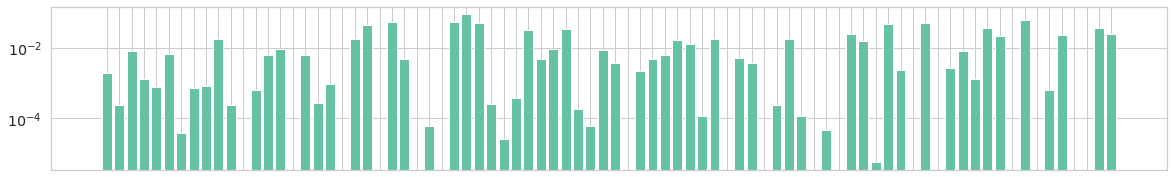

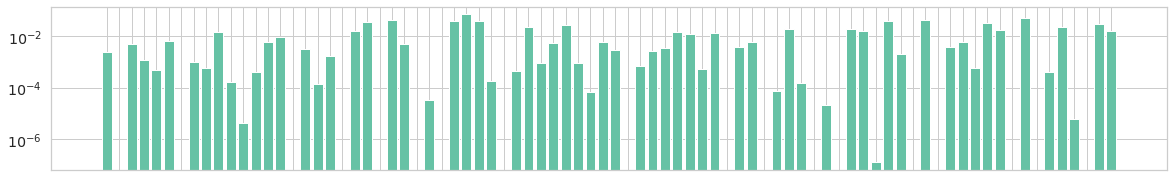

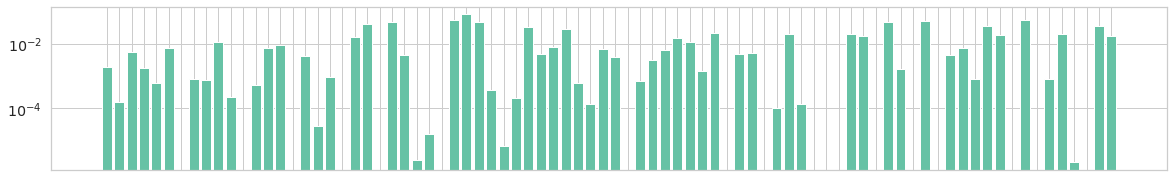

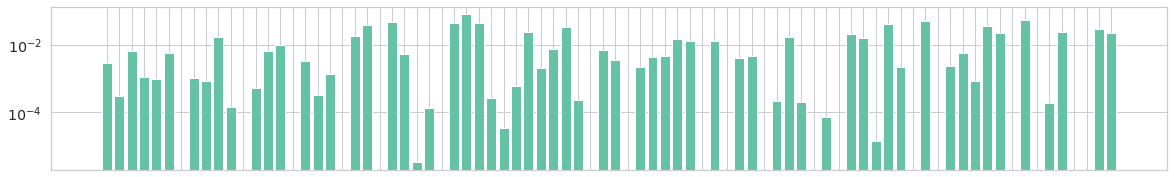

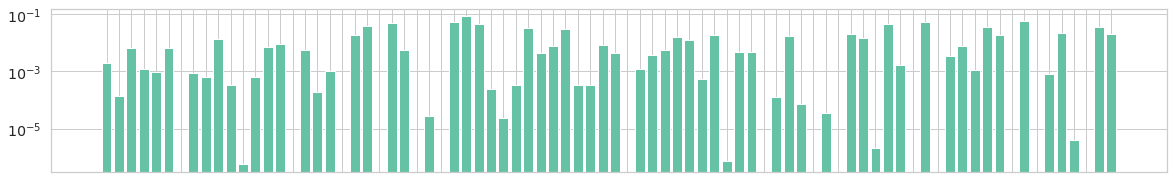

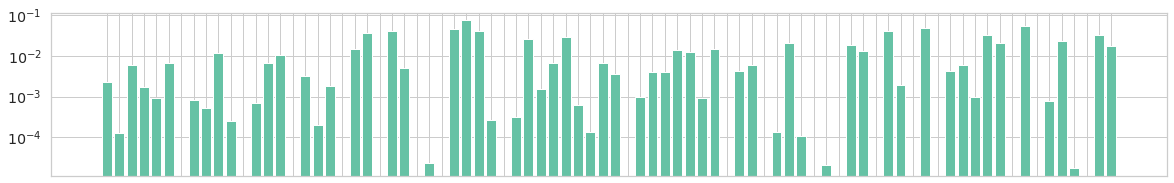

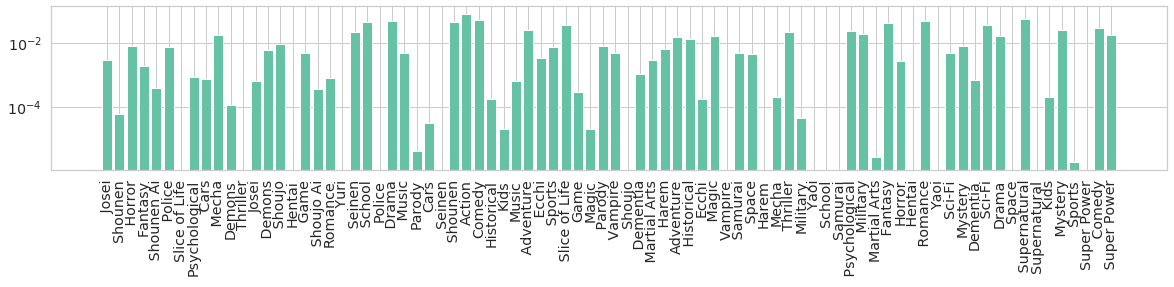

In [40]:
for i in range(7):
    plt.figure(figsize=(20, 3))
    plt.bar(list(all_genres), labels_rate[i])
    plt.yscale('log')
    if i < 6:
        plt.xticks(labels_rate[i].index, ['' for i in range(len(all_genres))])
plt.xticks(rotation='90');

Проверим с помощью критерия Фридмана гипотезу неразличимости кластеров. В качестве объектов выступают жанры, а в качестве признаков -- кластеры. Выборки являются связными.

In [41]:
sps.friedmanchisquare(*labels_rate)

FriedmanchisquareResult(statistic=50.72000000000014, pvalue=3.371144164449225e-09)

p-value получился маленьким, значит какие-то кластеры различаются.  
Проверим с помощью критерия ранговых сумм Вилкиксона для парных выборок гипотезы о неразличимости всех пар кластеров. 

**Внимание.** Корректнее делать соответствующий post-hoc анализ, но для этого надо воспользоваться R.

In [42]:
labels = ['Кластер {}'.format(j) for j in range(8)]
pvalues = pd.DataFrame(columns=labels, index=labels)

for i in range(7):
    for j in range(i+1, 7):
        pvalues.iloc[i, j] = sps.wilcoxon(labels_rate[i], labels_rate[j])[1]

In [43]:
pvalues

,Кластер 0,Кластер 1,Кластер 2,Кластер 3,Кластер 4,Кластер 5,Кластер 6,Кластер 7
Кластер 0,NaN,1.54072e-06,0.0105755,7.14738e-05,0.00159455,6.52845e-06,0.0470708,NaN
Кластер 1,NaN,NaN,0.00013203,0.000169717,1.26005e-05,0.00733752,6.38248e-06,NaN
Кластер 2,NaN,NaN,NaN,0.259689,0.0504309,0.0197536,0.355665,NaN
Кластер 3,NaN,NaN,NaN,NaN,0.08191,0.0266994,0.0486925,NaN
Кластер 4,NaN,NaN,NaN,NaN,NaN,8.86799e-05,0.478575,NaN
Кластер 5,NaN,NaN,NaN,NaN,NaN,NaN,0.00173634,NaN
Кластер 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Кластер 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проведем множественную проверку гипотез при помощи метода Холма

In [44]:
pvalues_list = []

for i in range(7):
    for j in range(i+1, 7):
        pvalues_list.append(pvalues.iloc[i, j])

pvalues_corrected = multipletests(pvalues_list, method='holm')[1]

In [45]:
labels = ['Кластер {}'.format(j) for j in range(7)]
pvalues = pd.DataFrame(columns=labels, index=labels)

ind = 0
for i in range(7):
    for j in range(i+1, 7):
        pvalues.iloc[i, j] = pvalues_corrected[ind]
        ind += 1
        
pvalues

,Кластер 0,Кластер 1,Кластер 2,Кластер 3,Кластер 4,Кластер 5,Кластер 6
Кластер 0,NaN,3.23552e-05,0.105755,0.00121505,0.0207291,0.00012765,0.329495
Кластер 1,NaN,NaN,0.00198045,0.00237604,0.000226808,0.0807127,0.00012765
Кластер 2,NaN,NaN,NaN,0.779066,0.329495,0.177782,0.779066
Кластер 3,NaN,NaN,NaN,NaN,0.329495,0.213595,0.329495
Кластер 4,NaN,NaN,NaN,NaN,NaN,0.00141888,0.779066
Кластер 5,NaN,NaN,NaN,NaN,NaN,NaN,0.0208361
Кластер 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Определим, между какими кластерами получилось стат. значимое различие. 
Уровень доверия поставим $alpha = 0.1$, так это промежуточный этап исследования, и требуется найти "что-то интересное".

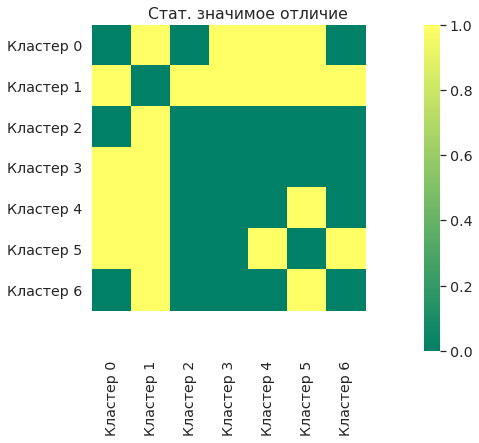

In [46]:
is_reject = pvalues <= 0.1
is_reject = is_reject | is_reject.T

plt.figure(figsize=(7, 6))
sns.heatmap(is_reject, cmap='summer')
plt.xlim((0, 8)), plt.ylim((8, 0));
plt.title('Стат. значимое отличие');

Посчитаем стандартное отклоение по жанрам между кластерами. Выведем топ 10 жанров, по которым наибольшее различие в кластерах.

In [47]:
sorted_var = np.log(pd.DataFrame(labels_rate)).std().sort_values(ascending=False)
sorted_var.head(10)

Martial Arts    1.781303
Thriller        1.426862
Ecchi           0.965156
Magic           0.952382
Sports          0.915904
 Shoujo Ai      0.877416
Cars            0.702967
 Ecchi          0.647677
 Kids           0.644278
Kids            0.625985
dtype: float64

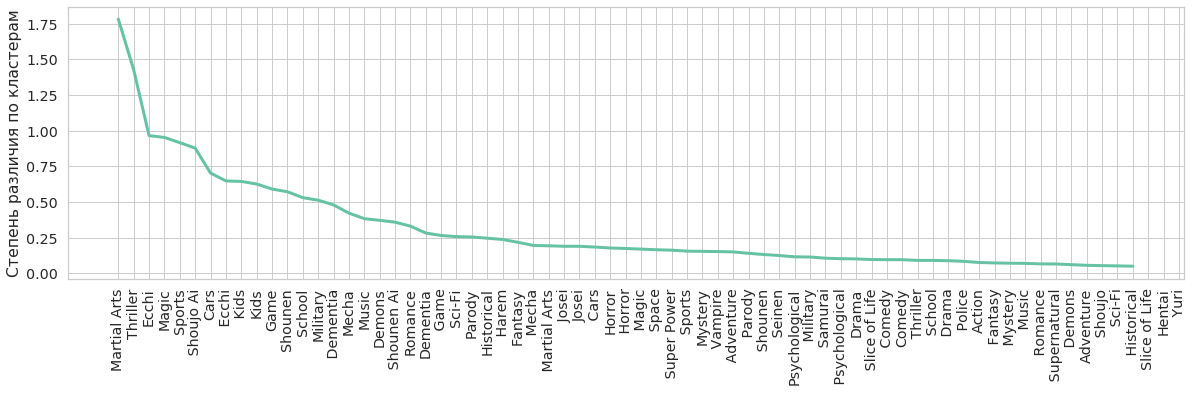

In [48]:
plt.figure(figsize=(20, 5))
plt.plot(sorted_var, lw=3)
plt.ylabel('Степень различия по кластерам')
plt.xticks(rotation='90');

Визуализируем кластеры по наиболее различающимся жанрам.

In [49]:
top_differ = sorted_var.head(10).index

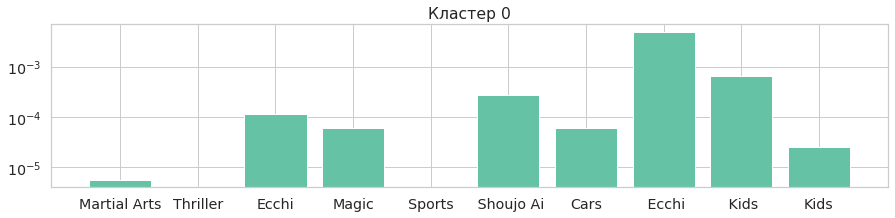

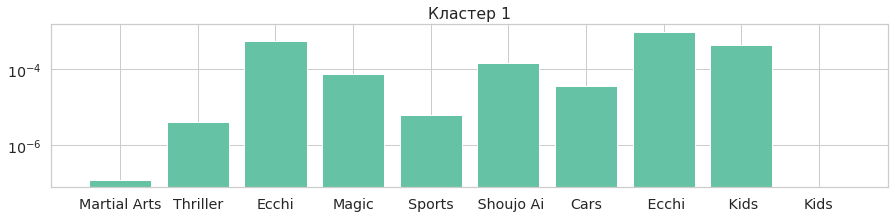

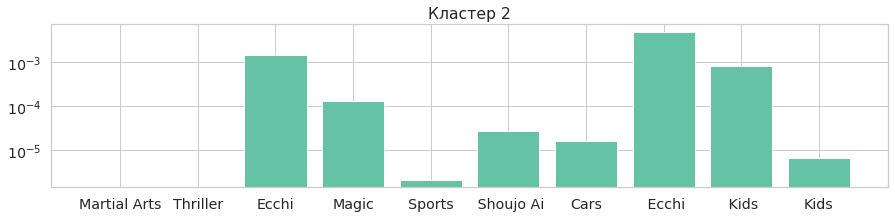

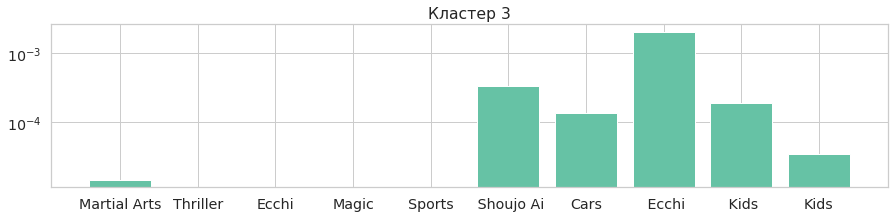

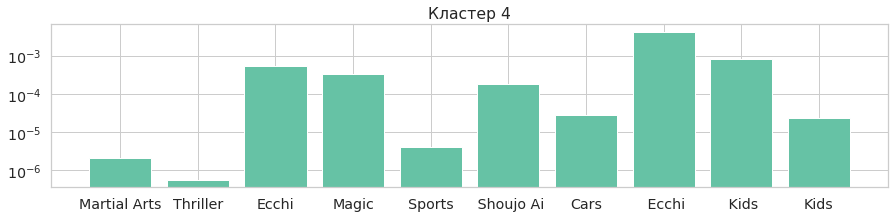

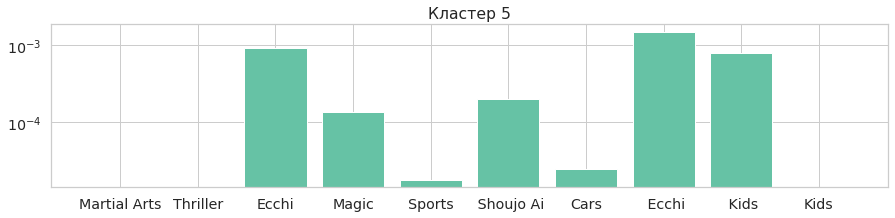

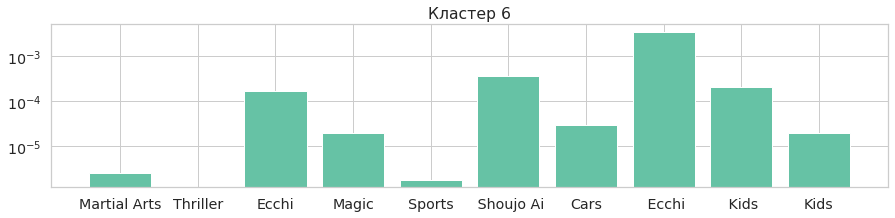

In [50]:
for i in range(7):
    plt.figure(figsize=(15, 3))
    plt.bar(top_differ, labels_rate[i].loc[top_differ])
    plt.yscale('log')
    plt.title('Кластер {}'.format(i))

По данным графикам, видно, что между кластерами есть существенные различия по выделенным жанрам.